In [61]:
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ModelCheckpoint
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import layer_utils, np_utils
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from classification_models import ResNet18
from classification_models.resnet import preprocess_input
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import class_weight
import seaborn as sn
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from scipy.sparse import csr_matrix

In [37]:
image_width = 224
image_height = 224

# Change the batchsize according to your system RAM
batch_size = 64

train_dir = "D:/retinal_data_set_visioncare/New_Train_Test_Data/train/"
test_dir = "D:/retinal_data_set_visioncare/New_Train_Test_Data/test/"

resnet_base = ResNet18(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [38]:
x = resnet_base.get_layer(index=-1).output
feature_extraction_layer = GlobalAveragePooling2D()(x)
model = Model(inputs=resnet_base.input, outputs=feature_extraction_layer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [39]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)

nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)

# get the class lebels for the training data, in the original order  
train_labels = train_generator.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 741 images belonging to 5 classes.


In [40]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

nb_test_samples = len(test_generator.filenames)
test_labels = test_generator.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 186 images belonging to 5 classes.


In [41]:
model_check_point_loc = 'D:/retinal_data_set_visioncare/models/resnet18/resnet_deep_feature_with_SVD_SVM_dr.h5'

In [42]:
train_data = np.load(open('D:/retinal_data_set_visioncare/models/resnet18/bottle_neck_features/bottleneck_features_train_without_aug.npy', 'rb'))
test_data = np.load(open('D:/retinal_data_set_visioncare/models/resnet18/bottle_neck_features/bottleneck_features_test_without_aug.npy', 'rb'))

In [43]:
train_data_labels = train_generator.classes

In [44]:
# Feature Scaling - fature normalizing
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)

In [45]:
# Make sparse matrix
X_sparse = csr_matrix(X_train)

In [46]:
# Run Truncated Singular Value Decomposition
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(X_train)

In [47]:
# list of explained variance ratios
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_
cum_var_exp = np.cumsum(tsvd_var_ratios)

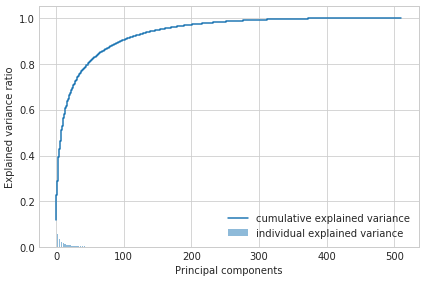

In [48]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(tsvd_var_ratios)), tsvd_var_ratios, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [49]:
# Create Function Calculating Number Of Components Required To Pass Threshold
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [50]:
# Run function
number_of_components = select_n_components(tsvd_var_ratios, 0.95)

In [51]:
number_of_components

156

In [52]:
truncated_opt_svd = TruncatedSVD(n_components=number_of_components, random_state=42)
transformed_X_train = truncated_opt_svd.fit_transform(X_train)
transformed_X_test = truncated_opt_svd.transform(X_test)

In [53]:
X = transformed_X_train
#X = transformed_data
Y = train_data_labels

In [54]:
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data_labels)
                                               ,train_data_labels)

In [55]:
class_weight_dic = dict(enumerate(class_weight))

In [86]:
# define 5-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=25)
cvscores = []
trainScores = []
f1Score = []
num_k_folds = 5
fold_counter = 0
val_conmats = []
val_precisions = []
val_recalls = []
val_f_scores = []
input_dim = 156

svm_classifier = SVC(kernel='linear', C=0.5, class_weight=class_weight_dic)

In [87]:
for train, test in kfold.split(X, Y):
    # Fit the model
    svm_classifier.fit(X[train], Y[train])
    
    y_train_pred = svm_classifier.predict(X[train])
    #y_train_pred = np.argmax(y_train_pred, axis=1)
    
    y_validation_pred = svm_classifier.predict(X[test])
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    
    [precision, recall, f_score, _] = precision_recall_fscore_support(Y[test], y_validation_pred)
    #print("Validation k-fold #%d - precision: %f, recallL: %f, f-score: %f" % (fold_counter, precision, recall, f_score))
    
    conmat = confusion_matrix(Y[test], y_validation_pred)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f_scores.append(f_score)
    val_conmats.append(conmat)
    fold_counter = fold_counter + 1
    
    trainScores.append(accuracy_score(Y[train], y_train_pred))
    cvscores.append(accuracy_score(Y[test], y_validation_pred))
    
print("\nAveraging the 5-fold results:")
print("%s: %.2f%%" % ('AVG Train Acc ', np.mean(trainScores) * 100))
print("%s: %.2f%%" % ('AVG Validation Acc ', np.mean(cvscores) * 100))
print("Validation precision - mean: %f, stddev: %f" % (np.mean(val_precisions), np.std(val_precisions)))
print("Validation recall - mean: %f, stddev: %f" % (np.mean(val_recalls), np.std(val_recalls)))
print("Validation f-score - mean: %f, stddev: %f" % (np.mean(val_f_scores), np.std(val_f_scores)))
print("Confusion matrix:")
print (sum(val_conmats).astype(float) / fold_counter)


Averaging the 5-fold results:
AVG Train Acc : 99.28%
AVG Validation Acc : 70.85%
Validation precision - mean: 0.648161, stddev: 0.205236
Validation recall - mean: 0.617233, stddev: 0.196768
Validation f-score - mean: 0.627304, stddev: 0.192419
Confusion matrix:
[[6.704e+01 1.124e+01 1.240e+00 0.000e+00 8.000e-02]
 [1.040e+01 5.960e+00 2.800e+00 8.000e-02 1.600e-01]
 [3.320e+00 3.680e+00 1.552e+01 2.800e-01 1.000e+00]
 [4.000e-02 1.200e-01 1.200e+00 6.240e+00 2.600e+00]
 [4.000e-01 2.800e-01 1.840e+00 2.440e+00 1.024e+01]]


In [24]:
y_train_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,